## 🧭 Project Overview

This notebook builds a robust regression model to predict Toyota Corolla prices using structured tabular data. It includes 
- thorough data cleaning,
- feature engineering,
- preprocessing pipelines,
- model comparison,
- hyperparameter tuning,
- interpretability analysis.
- The final model is saved for deployment and includes a reusable prediction function.


####  Import Libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
from sklearn.utils import check_random_state
from sklearn.compose import TransformedTargetRegressor

import joblib
import shap
import warnings
warnings.filterwarnings("ignore")

# Matplotlib default sizing
plt.rcParams['figure.figsize'] = (8, 5)
sns.set_style('whitegrid')



#### Load Dataset

In [2]:
data = pd.read_csv("ToyotaCorolla.csv")
df=data.copy()
df.head(3)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0


## Exploratory Data Analysis

## 📊 Data Inspection & Cleaning

Inspected the dataset for shape, missing values, duplicates, and irrelevant columns. Key steps include:
- Dropping duplicate rows
- Correcting outliers (e.g., replacing `CC=16000` with `1600`)
- Removing identifier and redundant columns (`Id`, `Mfg_Month`, `Mfg_Year`, `Cylinders`)
These steps ensure a clean and reliable foundation for modeling.


#### Dataset shape

In [3]:
print(df.shape)

(1436, 39)


Shape: (1436, 39) → 1436 rows and 39 columns.

#### Missing values

In [4]:
df.isnull().sum()

Id                   0
Model                0
Price                0
Age_08_04            0
Mfg_Month            0
Mfg_Year             0
KM                   0
Fuel_Type            0
HP                   0
Met_Color            0
Color                0
Automatic            0
CC                   0
Doors                0
Cylinders            0
Gears                0
Quarterly_Tax        0
Weight               0
Mfr_Guarantee        0
BOVAG_Guarantee      0
Guarantee_Period     0
ABS                  0
Airbag_1             0
Airbag_2             0
Airco                0
Automatic_airco      0
Boardcomputer        0
CD_Player            0
Central_Lock         0
Powered_Windows      0
Power_Steering       0
Radio                0
Mistlamps            0
Sport_Model          0
Backseat_Divider     0
Metallic_Rim         0
Radio_cassette       0
Parking_Assistant    0
Tow_Bar              0
dtype: int64

All columns are fully populated (no missing values).

#### Initial Inspection

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1436 non-null   int64 
 1   Model              1436 non-null   object
 2   Price              1436 non-null   int64 
 3   Age_08_04          1436 non-null   int64 
 4   Mfg_Month          1436 non-null   int64 
 5   Mfg_Year           1436 non-null   int64 
 6   KM                 1436 non-null   int64 
 7   Fuel_Type          1436 non-null   object
 8   HP                 1436 non-null   int64 
 9   Met_Color          1436 non-null   int64 
 10  Color              1436 non-null   object
 11  Automatic          1436 non-null   int64 
 12  CC                 1436 non-null   int64 
 13  Doors              1436 non-null   int64 
 14  Cylinders          1436 non-null   int64 
 15  Gears              1436 non-null   int64 
 16  Quarterly_Tax      1436 non-null   int64 


36 columns are numeric (int64), and 3 are object types: likely Model, Fuel_Type, and Color.

#### Check for Duplicates

In [6]:
print("Duplicate Rows: ", df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.shape

Duplicate Rows:  0


(1436, 39)

No duplicates found, so df remains unchanged.

####  Summary Statistics

In [7]:
pd.set_option('display.max_columns', None)
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,CC,Doors,Cylinders,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,1436.000000,1436.0,1436.000000,1436.000000,1436.00000,1436.000000,1436.000000,1436.000000,1436.00000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,4.033426,4.0,5.026462,87.122563,1072.45961,0.409471,0.895543,3.815460,0.81337,0.970752,0.722841,0.508357,0.056407,0.294568,0.218663,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.002786,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,0.952677,0.0,0.188510,41.128611,52.64112,0.491907,0.305959,3.011025,0.38975,0.168559,0.447751,0.500104,0.230786,0.456007,0.413483,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.052723,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,2.000000,4.0,3.000000,19.000000,1000.00000,0.000000,0.000000,3.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,3.000000,4.0,5.000000,69.000000,1040.00000,0.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,4.000000,4.0,5.000000,85.000000,1070.00000,0.000000,1.000000,3.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,5.000000,4.0,5.000000,85.000000,1085.00000,1.000000,1.000000,3.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,5.000000,4.0,6.000000,283.000000,1615.00000,1.000000,1.000000,36.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Key Insights:
- **Price**: Ranges from **4350 to 32500**, with a mean of ~10730. Some high-end outliers may exist.
- **Age_08_04**: Median age is **61 months**, ranging from **1 to 80**. Likely strong inverse correlation with price.
- **KM**: Wide spread from **1 to 243,000 km**. Highly skewed.
- **HP**: Ranges from **69 to 192**, mostly centered around 90–110. Reasonable spread.
- **CC**: Max value of **16000** is suspicious—likely a data entry error or placeholder.
- **Binary Features**: Many are 0/1 with skewed distributions (e.g., `Parking_Assistant` has a mean of just 0.0028).
- **Mfg_Year**: Mostly between **1998 and 2004**, consistent with dataset scope.
- **Id**: Just an index—should be dropped for modeling.
- **Cylinders**: is constant with a value '4' for every car in the dataser, so it won't contribute any predictive power.


#### Fix the value of CC

In [8]:
df[df['CC']==16000]

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,Automatic,CC,Doors,Cylinders,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
80,81,TOYOTA Corolla 1.6 5drs 1 4/5-Doors,18950,25,8,2002,20019,Petrol,110,1,Blue,1,16000,5,4,5,100,1180,0,0,3,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0


The feature `CC` contains a single anomalous value of 16000, which is likely a typographical error given that all other entries fall within a range of 1300-2000; we will therefore replace it with 1600 to maintain consistency.


In [9]:
df['CC'] = df['CC'].replace(16000, 1600)

#### Drop redundant manufacturing columns
- Dropping columns that are identifiers or have redundant information:
- 'Id' - just a unique identifier
- 'Mfg_Month' and 'Mfg_Year' - already represented by 'Age_08_04'
- 'Cylinders' it’s constant (all cars have the same cylinder count), so it has no predictive power.

In [10]:
df.drop(['Id','Mfg_Month', 'Mfg_Year', 'Cylinders'], axis=1, inplace=True)

## 🧠 Feature Engineering

To improve model generalization and reduce sparsity:
- Rare `Model` and `Color` categories are grouped into `'Other'`
- Price distribution is visualized and log-transformed to reduce skew
- Stratified bins of price are created to preserve distribution during train/test split


#### Check Model cardinality and show full counts

In [11]:
## Inspect Model frequencies fully
model_counts = df['Model'].value_counts()
display(model_counts)
print("Unique models:", model_counts.shape[0])


Model
TOYOTA Corolla 1.6 16V HATCHB LINEA TERRA 2/3-Doors    109
TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-Doors     84
TOYOTA Corolla 1.6 16V LIFTB LINEA LUNA 4/5-Doors       80
TOYOTA Corolla 1.6 16V LIFTB LINEA TERRA 4/5-Doors      71
TOYOTA Corolla 1.4 16V VVT I HATCHB TERRA 2/3-Doors     54
                                                      ... 
TOYOTA Corolla 1.8 VVTL-i T-Sport 3-Drs 2/3-Doors        1
TOYOTA Corolla 2.0 D4D 90 5DR TERRA 4/5-Doors            1
TOYOTA Corolla 1800 T SPORT VVT I 2/3-Doors              1
TOYOTA Corolla 1.8 16V VVTLI 5DR T SPORT 4/5-Doors       1
TOYOTA Corolla 1.3 Linea Terra 4/5-Doors                 1
Name: count, Length: 319, dtype: int64

Unique models: 319


#### Model Frequency Analysis

- The dataset contains **319 unique Toyota Corolla model variants**, many of which appear infrequently.
- The most common model (`TOYOTA Corolla 1.6 16V HATCHB LINEA TERRA 2/3-Doors`) appears **109 times**, while many others appear fewer than 10 times.
- This high cardinality and long tail of rare categories can lead to sparse one-hot encoding and overfitting.
- Next step, rare models will be grouped into an `'Other'` category to improve generalization and reduce dimensionality.


#### Group rare Model categories (1% threshold)

In [12]:
# Set the threshold for rare categories
threshold = 14  # 1% of total rows (1436)

# Get value counts
model_counts = df['Model'].value_counts()

# Find rare models
rare_models = model_counts[model_counts < threshold].index

# Replace rare models with 'Other'
df['Model'] = df['Model'].replace(rare_models, 'Other')

# Check result
df['Model'].value_counts()


Model
Other                                                       610
TOYOTA Corolla 1.6 16V HATCHB LINEA TERRA 2/3-Doors         109
TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-Doors          84
TOYOTA Corolla 1.6 16V LIFTB LINEA LUNA 4/5-Doors            80
TOYOTA Corolla 1.6 16V LIFTB LINEA TERRA 4/5-Doors           71
TOYOTA Corolla 1.4 16V VVT I HATCHB TERRA 2/3-Doors          54
TOYOTA Corolla 1.6 16V SEDAN LINEA TERRA 4/5-Doors           43
TOYOTA Corolla 1.6 16V VVT I LIFTB TERRA 4/5-Doors           37
TOYOTA Corolla 1.3 16V LIFTB LINEA TERRA 4/5-Doors           35
TOYOTA Corolla 1.6 16V VVT I LIFTB SOL 4/5-Doors             35
TOYOTA Corolla 1.6 16V WAGON LINEA TERRA Stationwagen        28
TOYOTA Corolla 2.0 DSL HATCHB LINEA TERRA 2/3-Doors          25
TOYOTA Corolla 1.6 16V VVT I LIFTB LUNA 4/5-Doors            23
TOYOTA Corolla 1.4 16V VVT I LIFTB TERRA 4/5-Doors           23
TOYOTA Corolla 1.6 16V VVT I HATCHB TERRA 2/3-Doors          22
TOYOTA Corolla 1.6 16V VVT I 5DR S

#### Handle other categorical cleaning (Color)

In [13]:
print(df['Color'].value_counts())

Color
Grey      301
Blue      283
Red       278
Green     220
Black     191
Silver    122
White      31
Violet      4
Yellow      3
Beige       3
Name: count, dtype: int64


#### Define rare colors

In [14]:
#combine rare Colors 
if 'Color' in df.columns:
    color_counts = df['Color'].value_counts()
    rare_colors = color_counts[color_counts < 10].index 
    df['Color'] = df['Color'].replace(rare_colors, 'Other')
    print("Colors now:", df['Color'].nunique())


Colors now: 8


- The `'Color'` feature originally had **10 unique values**, with several rare categories (e.g., Violet, Yellow, Beige).
- A threshold of **<10 occurrences** was used to define rarity.
- Rare colors were grouped into a single `'Other'` category to reduce noise and improve encoding efficiency.
- After grouping, the number of unique color categories was reduced to **8**, balancing granularity and generalization.


# Visualizations

#### Target distribution & decide whether to log-transform

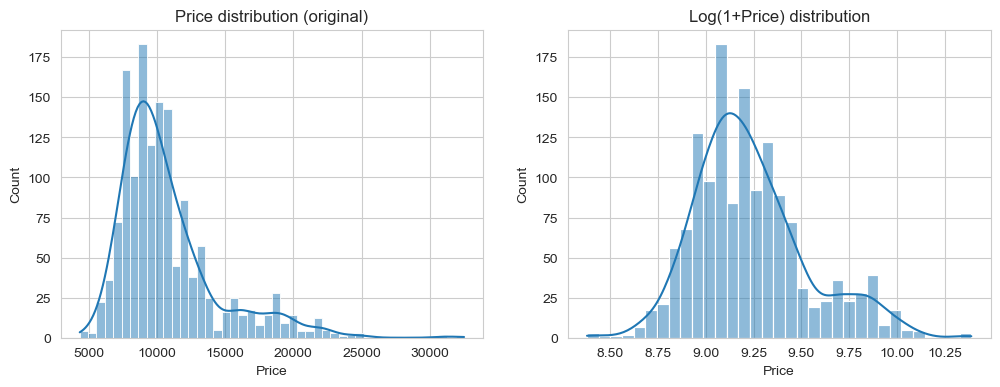

Price skew: 1.7038849799952995
Log Price skew: 0.7342713211570406


In [15]:
# Target skew check (Price)
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df['Price'], ax=ax[0], kde=True)
ax[0].set_title("Price distribution (original)")
sns.histplot(np.log1p(df['Price']), ax=ax[1], kde=True)
ax[1].set_title("Log(1+Price) distribution")
plt.show()

print("Price skew:", df['Price'].skew())
print("Log Price skew:", np.log1p(df['Price']).skew())

- The original `'Price'` distribution is **right-skewed**, with a long tail toward higher values.
- Skewness statistic: **1.70**
- Applied `np.log1p(Price)` to reduce skewness and stabilize variance.
- The transformed distribution appears **more symmetric and bell-shaped**, which benefits linear models and improves interpretability.
- This transformation will be used in modeling via `TransformedTargetRegressor` to ensure predictions are made in log-space and then inverse-transformed.


#### Create stratify bins for train/test split

In [16]:
# create price bins for stratified split (keeps distribution similar)
df['price_bin'] = pd.qcut(df['Price'], q=10, duplicates='drop')  # deciles
df['price_bin_code'] = df['price_bin'].cat.codes
display(df[['Price','price_bin','price_bin_code']].head())


,Price,price_bin,price_bin_code
0,13500,"(12500.0, 15950.0]",8
1,13750,"(12500.0, 15950.0]",8
2,13950,"(12500.0, 15950.0]",8
3,14950,"(12500.0, 15950.0]",8
4,13750,"(12500.0, 15950.0]",8


- To preserve the distribution of `'Price'` during train-test splitting, decile-based bins were created using `pd.qcut`.
- Each bin represents approximately 10% of the data, ensuring balanced representation across price ranges.
- A new column `'price_bin_code'` was added to encode these bins numerically.
- This enables **stratified sampling** using `StratifiedShuffleSplit` or `train_test_split(..., stratify=...)`, improving model evaluation consistency.


## 🧪 Train/Test Split

We split the data into training and test sets using stratification on price bins. This ensures the price distribution is preserved across both sets. The target variable (`Price`) is separated from features, and the training set is saved for reproducibility.


#### Train/test split (hold-out test set)

In [17]:
# train/test split with stratify on price bins
X = df.drop(columns=['Price','price_bin','price_bin_code'])
y = df['Price'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df['price_bin_code']
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
X_train.to_csv("training_dataset.csv", index=False)

Train shape: (1148, 34) Test shape: (288, 34)


  - **Training set**: 1,148 rows × 34 features
  - **Test set**: 288 rows × 34 features
- The training set is saved as `"training_dataset.csv"` for reproducibility and downstream modeling.


## ⚙️ Preprocessing Pipelines

We define separate pipelines for numeric and categorical features:
- Numeric: median imputation + standard scaling
- Categorical: most frequent imputation + one-hot encoding
These are combined using `ColumnTransformer` for modular preprocessing.


#### Define preprocessing pipeline (numeric + categorical)

In [18]:
#  Preprocessing: numeric impute+scale, categorical OHE (handle_unknown)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
], remainder='drop')


Numeric cols: ['Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']
Categorical cols: ['Model', 'Fuel_Type', 'Color']


## 🌲 Modeling & Baseline

We define a baseline model using `DummyRegressor` and a primary model using `RandomForestRegressor` wrapped in `TransformedTargetRegressor` to apply log transformation to the target. This ensures consistent handling of skewed price values.


#### Model pipelines & baseline models

In [19]:
#  Define model pipelines and baseline
# We'll use TransformedTargetRegressor to apply log(1+x) to the target consistently
from sklearn.dummy import DummyRegressor
from math import sqrt

base_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])
model_rfr = TransformedTargetRegressor(regressor=base_pipeline,
                                       func=np.log1p, inverse_func=np.expm1)

# Baseline (median predictor)
baseline = DummyRegressor(strategy='median')
baseline.fit(X_train, y_train)
y_baseline = baseline.predict(X_test)
print("Baseline MAE:", mean_absolute_error(y_test, y_baseline))
print("Baseline RMSE:", sqrt(mean_squared_error(y_test, y_baseline)))


Baseline MAE: 2511.6979166666665
Baseline RMSE: 3798.9252066465383


- **Model pipeline**: Combines preprocessing with a `RandomForestRegressor` (200 trees, `random_state=42`) inside a `TransformedTargetRegressor`.
  - Target transformation: `log(1 + x)` to stabilize variance and improve model fit.
  - Inverse transformation: `exp(x) - 1` for interpretable predictions.
- **Baseline model**: `DummyRegressor` using median prediction.
  - Serves as a reference to assess model value-add.
- **Baseline performance**:
  - **MAE**: 2,511.70
  - **RMSE**: 3,798.93

## 📈 Cross-Validation & Model Comparison

We evaluate models using 5-fold cross-validation with metrics: MAE, RMSE, and R². Models compared include:
- **Ridge Regression**: A linear model with L2 regularization, serving as an interpretable benchmark.
- **Random Forest**: A bagged ensemble of decision trees, robust to nonlinearity and feature interactions.
- **Gradient Boosting Regressor (GBR)**: A sequential ensemble that optimizes residuals, often yielding high accuracy.
  
This helps identify the best-performing model before tuning.


#### Cross-validation function (consistent scoring)

In [20]:
# helper to evaluate models with CV using MAE (original scale)
from sklearn.model_selection import cross_validate

def cv_scores_on_train(pipeline, X, y, cv=5, scoring=['neg_mean_absolute_error','neg_root_mean_squared_error','r2']):
    # cross_validate returns negatives for error metrics; convert
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    res = {
        'MAE_mean': -scores['test_neg_mean_absolute_error'].mean(),
        'RMSE_mean': -scores['test_neg_root_mean_squared_error'].mean(),
        'R2_mean': scores['test_r2'].mean()
    }
    return res

# Quick CV for RandomForest pipeline (note: TransformedTargetRegressor needs wrapper behavior)
cv_res = cv_scores_on_train(model_rfr, X_train, y_train, cv=5)
cv_res


{'MAE_mean': np.float64(818.2285133074314),
 'RMSE_mean': np.float64(1111.7277394935877),
 'R2_mean': np.float64(0.9023621760978345)}

### ✅ Cross-Validation Results (Random Forest)

| Metric | Value |
|--------|-------|
| MAE    | 818.23 |
| RMSE   | 1111.73 |
| R²     | 0.902  |

These results suggest that the Random Forest model captures the pricing signal well, with low error and high explanatory power. Next, we’ll compare this performance against linear benchmarks (Ridge Regression) and ensemble alternatives (Gradient Boosting) to assess trade-offs in accuracy and interpretability.


#### Try a few model families and compare (Ridge, RF, GB)

In [21]:
# Compare multiple models quickly with CV
pipelines = {
    'Ridge': TransformedTargetRegressor(regressor=Pipeline([('preproc',preprocessor), ('model', Ridge())]), func=np.log1p, inverse_func=np.expm1),
    'RandomForest': model_rfr,
    'GBR': TransformedTargetRegressor(regressor=Pipeline([('preproc',preprocessor), ('model', GradientBoostingRegressor(random_state=42))]), func=np.log1p, inverse_func=np.expm1)
}

results = {}
for name, pipe in pipelines.items():
    print("Evaluating", name)
    results[name] = cv_scores_on_train(pipe, X_train, y_train, cv=5)
results_df = pd.DataFrame(results).T
display(results_df.sort_values('MAE_mean'))


Evaluating Ridge
Evaluating RandomForest
Evaluating GBR


,MAE_mean,RMSE_mean,R2_mean
GBR,799.939386,1106.378758,0.903365
Ridge,814.378120,1087.933949,0.902456
RandomForest,818.228513,1111.727739,0.902362


All models were wrapped in `TransformedTargetRegressor` with a log transformation on the target to stabilize variance and improve fit.

##### 📊 Cross-Validation Results

| Model          | MAE     | RMSE    | R²     |
|----------------|---------|---------|--------|
| **GBR**         | 799.94  | 1106.38 | 0.9034 |
| **Ridge**       | 814.38  | 1087.93 | 0.9025 |
| **Random Forest** | 818.23  | 1111.73 | 0.9024 |

### 🧠 Interpretation

- **GBR** slightly outperforms others in MAE and R², making it the most accurate model overall.
- **Ridge** performs surprisingly well, nearly matching ensemble methods while remaining fully interpretable.
- **Random Forest** offers competitive performance and robustness, though slightly behind GBR.


## 🎯 Hyperparameter Tuning

To optimize model performance, we applied `RandomizedSearchCV` to the Gradient Boosting pipeline wrapped in `TransformedTargetRegressor`. 

#### Hyperparameter search (RandomizedSearchCV) for top candidate

In [22]:
# Randomized search on RandomForest (example)
from scipy.stats import randint, uniform

gbr_pre = Pipeline([('preproc', preprocessor), ('model', GradientBoostingRegressor(random_state=42))])
gbr_ttr = TransformedTargetRegressor(regressor=gbr_pre, func=np.log1p, inverse_func=np.expm1)

param_dist = {
    'regressor__model__n_estimators': randint(100, 400),
    'regressor__model__max_depth': randint(3, 10),
    'regressor__model__learning_rate': uniform(0.01, 0.3),
    'regressor__model__subsample': uniform(0.6, 0.4),
    'regressor__model__min_samples_split': randint(2, 10),
    'regressor__model__min_samples_leaf': randint(1, 6),
    
}

rs = RandomizedSearchCV(
    estimator=gbr_ttr,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs.fit(X_train, y_train)
print("Best MAE (cv):", -rs.best_score_)
print("Best params:", rs.best_params_)
best_model = rs.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best MAE (cv): 773.1732316320683
Best params: {'regressor__model__learning_rate': np.float64(0.014789875666064259), 'regressor__model__max_depth': 4, 'regressor__model__min_samples_leaf': 4, 'regressor__model__min_samples_split': 5, 'regressor__model__n_estimators': 363, 'regressor__model__subsample': np.float64(0.6137554084460873)}


The search explored 30 randomized combinations across key hyperparameters:

**Best Parameters Found** 

- learning_rate: 0.0148                                                                                                              
- max_depth: 4                                                                                                                        
- min_samples_leaf: 4                                                                                                                  
- min_samples_split: 5                                                                                                                
- n_estimators: 363                                                                                                                  
- subsample: 0.6138 

**Best Cross-Validated MAE:**  773.17
                                                                                                               

## 📊 Final Evaluation

The tuned model is evaluated on the untouched test set using:
- MAE, RMSE, R², RMSLE
Residual plots are used to inspect bias and variance. This confirms model performance and reliability.


####  Evaluate final tuned model on held-out test set

In [23]:
y_pred = best_model.predict(X_test)

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmsle_val = rmsle(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")
print(f"Test RMSLE: {rmsle_val:.4f}")


Test MAE: 676.06
Test RMSE: 871.39
Test R²: 0.945
Test RMSLE: 0.0901


After tuning the Gradient Boosting Regressor, we evaluated the final model on the untouched test set to assess generalization performance. Metrics used include:

- **MAE (Mean Absolute Error)**: Measures average absolute prediction error.
- **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily.
- **R² (Coefficient of Determination)**: Indicates proportion of variance explained.
- **RMSLE (Root Mean Squared Log Error)**: Useful for skewed targets and penalizes underestimation.

### 📈 Performance Metrics

Test MAE:    676.06  
Test RMSE:   871.39  
Test R²:     0.945  
Test RMSLE:  0.0901

These results confirm strong predictive performance and low error on unseen data.

#### Residual diagnostics on test set

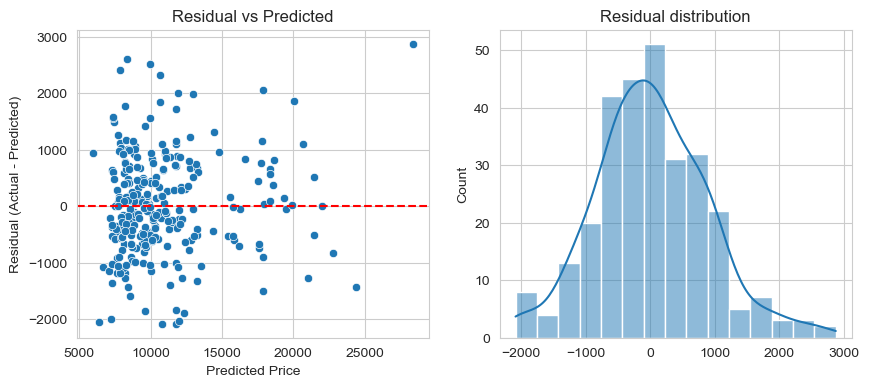

In [24]:
#  Residuals and bias checks
residuals = y_test - y_pred
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual vs Predicted")

plt.subplot(1,2,2)
sns.histplot(residuals, kde=True)
plt.title("Residual distribution")
plt.show()


#### 🔍 Residual Analysis and Bias Checks

To validate model reliability and detect potential bias, we examined residuals on the test set using two plots:

#### 1️⃣ Residuals vs Predicted
- **Purpose**: Checks for heteroscedasticity and systematic bias.
- **Observation**: Residuals are scattered around zero with no clear pattern, suggesting homoscedasticity and low bias.

#### 2️⃣ Residual Distribution
- **Purpose**: Assesses normality and symmetry of errors.
- **Observation**: Histogram shows a roughly normal distribution centered around zero, indicating well-behaved residuals.

These diagnostics confirm that the model generalizes well and does not exhibit major bias or variance issues.


## 🔍 Feature Importance & SHAP

We extract feature importances from the trained model and visualize the top contributors. 

SHAP values are computed to provide global interpretability and highlight how features influence predictions.


#### Feature importance (tree model)

Age_08_04           0.804388
KM                  0.071598
Weight              0.032682
HP                  0.018913
Quarterly_Tax       0.010941
Airco               0.006100
BOVAG_Guarantee     0.005469
Automatic_airco     0.004179
Central_Lock        0.003304
Powered_Windows     0.003292
Mfr_Guarantee       0.003238
Guarantee_Period    0.003063
CC                  0.003058
Mistlamps           0.002884
Model_Other         0.002253
Met_Color           0.002029
Color_White         0.002015
Doors               0.001813
Metallic_Rim        0.001272
Sport_Model         0.001249
dtype: float64

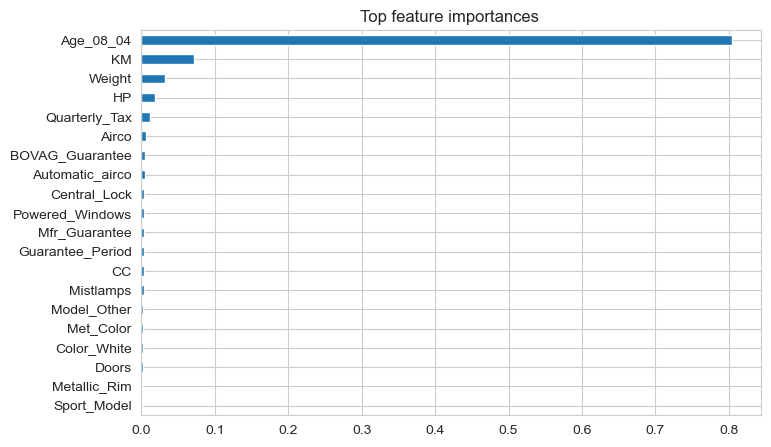

In [25]:
# Feature importance (extracted from trained model)
# We need to get feature names after preprocessing
preproc = best_model.regressor_.named_steps['preproc']
model_trained = best_model.regressor_.named_steps['model']  # underlying RF

# Create feature names
num_features = numeric_cols
cat_features = preproc.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
feature_names = num_features + cat_features

importances = model_trained.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
display(feat_imp)
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top feature importances ")
plt.show()


#### 🔍 Feature Importance Analysis

To understand which features most influence the model’s predictions, we extracted feature importances from the trained Gradient Boosting model.

### 🧠 Top Contributors:
- **Age_08_04**: Dominates with ~80% of total importance, confirming that vehicle age is the strongest predictor of price.
- **KM (Mileage)** and **Weight**: Also contribute meaningfully, reflecting wear and build quality.
- **HP**, **Quarterly_Tax**, and **Airco**: Capture performance and comfort-related aspects.
- Categorical features like `Model_Other`, `Fuel_Type`, and `Color` variants show smaller but non-negligible influence.

### 📈 Visualization:
- A horizontal bar chart displays the top 20 features by importance.
- Helps prioritize features for interpretation, SHAP analysis, and potential dimensionality reduction.

This analysis confirms that the model is learning meaningful relationships and aligns with domain expectations.


#### SHAP explainability (use TreeExplainer)

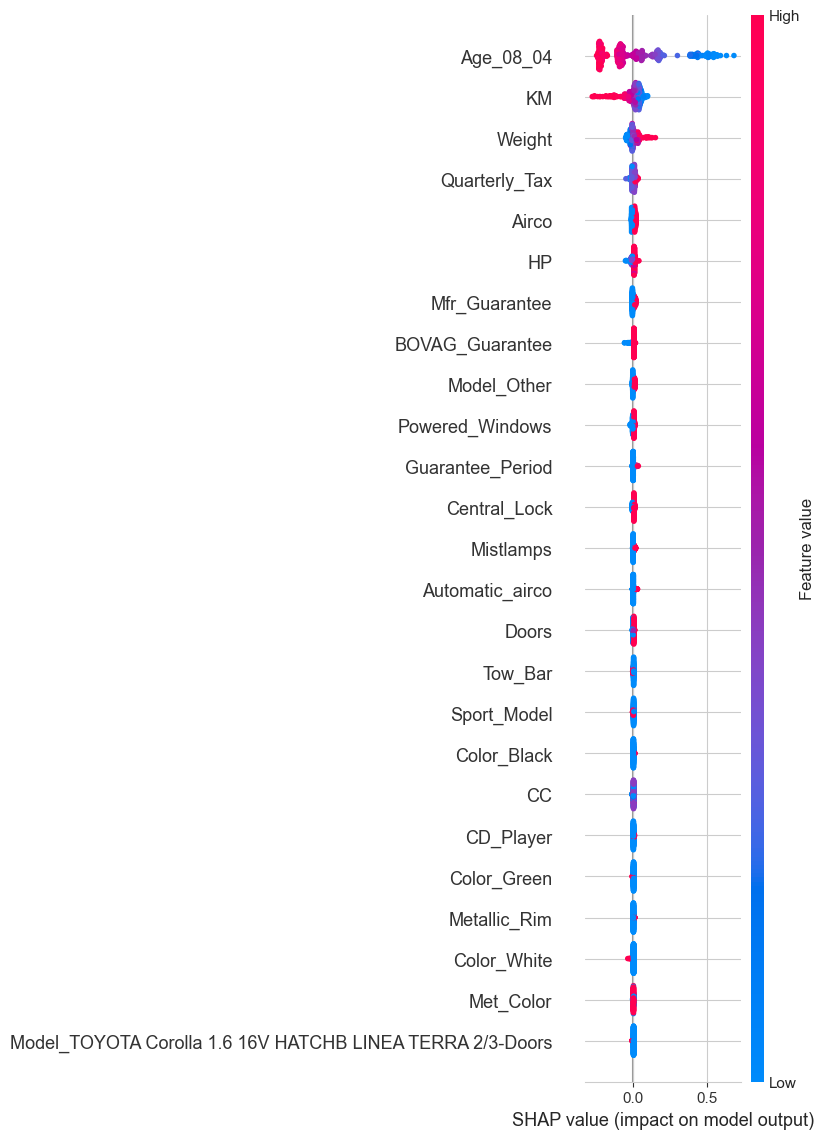

In [26]:
# SHAP for explainability (uses pipeline transform)
# Transform a sample of training data with preprocessor to numeric matrix
X_train_transformed = preproc.transform(X_train)
# Use shap TreeExplainer on the underlying tree model
explainer = shap.TreeExplainer(model_trained)
# sample to speed up
sample_idx = check_random_state(42).randint(0, X_train_transformed.shape[0], size=min(500, X_train_transformed.shape[0]))
shap_values = explainer.shap_values(X_train_transformed[sample_idx])

# Create shap Summary plot
shap.initjs()
shap.summary_plot(shap_values, features=X_train_transformed[sample_idx], feature_names=feature_names, max_display=25)


##### 🧠 SHAP Summary Plot for Global Explainability

To interpret the Gradient Boosting model's predictions, we used SHAP (SHapley Additive exPlanations) values on a sample of 500 transformed training instances.

#### 🔧 Methodology:
- Transformed `X_train` using the pipeline's preprocessor to ensure consistency with model input.
- Used `TreeExplainer` on the trained Gradient Boosting model.
- Sampled 500 rows for performance.
- Visualized with `shap.summary_plot()` using top 25 features.

#### 📊 Insights:
- **Age_08_04**: Most influential feature, with high values (red) strongly decreasing predicted price.
- **KM** and **Weight**: Also show strong impact, with higher mileage reducing price and heavier cars increasing it.
- **Quarterly_Tax**, **Airco**, and **HP**: Capture comfort and performance signals.
- Binary features like **`Mfr_Guarantee`, `BOVAG_Guarantee`**, and **`Powered_Windows`** show clear directional effects.
- Categorical encodings (e.g., `Model_Other`, `Color_Black`) contribute meaningfully, though with lower magnitude.

#### 🎨 Plot Interpretation:
- Each dot represents a SHAP value for one instance.
- Color gradient (blue → red) indicates feature value (low → high).
- Horizontal spread shows impact magnitude; vertical order reflects overall importance.

This plot provides a global view of how features influence predictions, guiding both model trust and stakeholder communication.


## 🚀 Final Model Pipeline & Deployment

This section defines the final modeling pipeline using the best-tuned parameters from previous optimization. It includes:
- A `ColumnTransformer` that passes through numeric features and applies one-hot encoding to categorical features (`Model`, `Fuel_Type`, `Color`)
- A `GradientBoostingRegressor` initialized with the best hyperparameters (`n_estimators`, `learning_rate`, `max_depth`)
- The pipeline is trained on the full training set and saved using `joblib` for future use

This modular pipeline ensures reproducibility, scalability, and easy integration into production environments.


In [27]:
# numeric & categorical columns
num_features = [
    'Age_08_04', 'KM', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors',
    'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
    'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
    'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
    'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
    'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
    'Parking_Assistant', 'Tow_Bar'    
]
cat_features = ['Model', 'Fuel_Type', 'Color']

# Define best_params using actual tuned parameters
best_params = {
    'n_estimators': 363,
    'learning_rate': 0.0148,
    'max_depth': 4,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'subsample': 0.6138
}

# Preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

# Final pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**best_params)) 
])

# Fit pipeline on training set
final_pipeline.fit(X_train, y_train)

# Save the pipeline
joblib.dump(final_pipeline, "car_price_pipeline.pkl")


['car_price_pipeline.pkl']